In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lichess_code 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)

In [ ]:
# This is what Lichess is doing
df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games_20.csv")

# Compute total accuracy, the function that Lichess uses
df=lichess_code.add_total_accuracy(df)
# collect it in summary table
summary_table=lichess_code.create_summary_table(df)

In [39]:
# Assuming 'df' contains the columns 'GameID', 'Player', and 'Total_Accuracy'
# Remove duplicates to ensure one entry per player per game
df_unique = df[['GameID', 'Player', 'Total_Accuracy']].drop_duplicates()
# Pivot the DataFrame to have 'Total_Accuracy' for White and Black in separate columns
df_pivot = df_unique.pivot(index='GameID', columns='Player', values='Total_Accuracy').reset_index()
# Remove the 'Player' name from columns
df_pivot.columns.name = None
# Optionally rename the columns for clarity
df_pivot.rename(columns={'White': 'Total_Accuracy_White', 'Black': 'Total_Accuracy_Black'}, inplace=True)
# Compute the minimum Total_Accuracy per game
df_pivot['Min_Total_Accuracy'] = df_pivot[['Total_Accuracy_White', 'Total_Accuracy_Black']].min(axis=1)
# Sort the DataFrame by 'Min_Total_Accuracy' in ascending order
df_sorted = df_pivot.sort_values('Min_Total_Accuracy', ascending=True)
# Get the top N games with the lowest minimum Total_Accuracy scores
N = 20  # Adjust N as needed
lowest_N_games = df_sorted.head(N)
# Display the GameID and both players' Total_Accuracy
print(f"Games with the lowest {N} minimum Total_Accuracy scores:")
print(lowest_N_games[['GameID', 'Total_Accuracy_White', 'Total_Accuracy_Black']])


Games with the lowest 20 minimum Total_Accuracy scores:
        GameID  Total_Accuracy_White  Total_Accuracy_Black
29143  32558.0             20.136249             20.654277
23095  25795.0             21.030625             28.959492
12885  13972.0             23.551820             23.962847
18764  20900.0             29.992533             25.168910
7674    8381.0             25.608673             57.963982
29194  32610.0             26.433581             25.882547
21423  23777.0             30.018454             27.888580
12952  14039.0             30.157351             30.142061
5316    5799.0             33.012618             30.512700
2714    2786.0             97.034244             31.086577
3814    4131.0             31.544381             75.416526
5285    5768.0             31.656920             40.565218
14007  15215.0             40.943737             31.913252
1936    1991.0             31.985342             35.928935
19154  21317.0             32.117766             34.970055


In [40]:
lichess_code.export_game_to_pgn(df,2786,'../game_example.pgn')

In [4]:
# Group by opening
top_openings = summary_table['Opening'].value_counts().nlargest(50).index.tolist()
summary_table['Opening'] = summary_table['Opening'].apply(lambda x: x if x in top_openings else 'Other')

# only take white
new_summary_table = summary_table[summary_table['Player'] == 'White'].copy()
#new_summary_table = new_summary_table[ (new_summary_table['TotalMoves'] <= 60)]

In [7]:
categorical_features = ['Opening', 'Variation', 'Result']
numerical_features = ['Total_Accuracy', 'TotalMoves']
test_size=0.2
random_state=42
# Prepare the feature matrix X and target vector y
features = categorical_features + numerical_features
X = summary_table[features]
y = summary_table['Elo']
# Handle missing values
X = X.fillna(0)
y = y.fillna(0)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)
# Create a ColumnTransformer to encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as is
)
# Create a pipeline that first transforms the data then applies Linear Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# Fit the model
pipeline.fit(X_train, y_train)
# Predict on the test set
y_pred = pipeline.predict(X_test)
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')
# Optional: Get the coefficients of the model
# Get feature names after one-hot encoding
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
# Combine with numerical feature names
feature_names = np.concatenate([onehot_feature_names, numerical_features])
# Get coefficients from the model
coefficients = pipeline.named_steps['regressor'].coef_
# Create a DataFrame to display feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
# Display the coefficients
print("\nCoefficients of the model:")
print(coef_df)


Root Mean Squared Error (RMSE): 489.61
R-squared Score (R²): 0.12

Coefficients of the model:
                         Feature  Coefficient
0     Opening_Alekhine's defence   -45.604834
1        Opening_Benko's opening    41.524870
2                 Opening_Benoni    38.598012
3         Opening_Benoni defence    58.435741
4         Opening_Bird's opening  -199.518176
...                          ...          ...
1028                  Result_1-0  -160.318115
1029               Result_1-0 ff   445.472156
1030              Result_1/2-1/2  -105.862244
1031              Total_Accuracy    14.078782
1032                  TotalMoves     0.523649

[1033 rows x 2 columns]


In [59]:
# Assume all necessary libraries are already imported and previous code has been executed
# The pipeline 'pipeline' has been trained, and 'categorical_features', 'numerical_features',
# and 'summary_table' are defined from your previous code.
# Step 1: Select 10 games with Elo > 2500
high_elo_games = summary_table[summary_table['Elo'] > 2500].copy()
# Check if there are at least 10 games; if not, adjust accordingly
if len(high_elo_games) < 10:
    print(f"Only {len(high_elo_games)} games found with Elo > 2500.")
    sample_games = high_elo_games
else:
    # Randomly select 10 games
    sample_games = high_elo_games.sample(n=20, random_state=42)
# Step 2: Preprocess the selected games
# Prepare the feature matrix
features = categorical_features + numerical_features
X_new = sample_games[features]
# Step 3: Predict using the trained model
y_new_pred = pipeline.predict(X_new)
# Step 4: Output the predictions per game
sample_games = sample_games.reset_index(drop=True)  # Reset index for clarity
sample_games['Predicted_Elo'] = y_new_pred
# Display the predictions per game
print("Predictions for each game:")
print(sample_games[['GameID', 'Elo', 'Predicted_Elo']])
# Step 5: Compute and display average, min, and max of the predictions
average_pred = y_new_pred.mean()
min_pred = y_new_pred.min()
max_pred = y_new_pred.max()
print(f"\nAverage Predicted Elo: {average_pred:.2f}")
print(f"Minimum Predicted Elo: {min_pred:.2f}")
print(f"Maximum Predicted Elo: {max_pred:.2f}")

Predictions for each game:
     GameID     Elo  Predicted_Elo
0   25067.0  2546.0    2246.600964
1   12593.0  2705.0    2170.308635
2    8579.0  2580.0    2302.718436
3   10414.0  2599.0    2243.326609
4   30444.0  2600.0    2409.715319
5    8550.0  2511.0    2310.712118
6    7893.0  2502.0    2370.633701
7   31211.0  2516.0    2296.789514
8    4009.0  2568.0    1959.657830
9    9942.0  2577.0    2377.379160
10   7861.0  2533.0    2448.744983
11  25198.0  2618.0    2327.059916
12  31270.0  2531.0    2210.506908
13  16055.0  2679.0    2312.456443
14   2556.0  2663.0    2244.618574
15   9943.0  2509.0    2295.124370
16   2120.0  2535.0    2029.656027
17  10555.0  2547.0    2353.301625
18  11657.0  2554.0    2319.320396
19  27254.0  2530.0    2290.502139

Average Predicted Elo: 2275.96
Minimum Predicted Elo: 1959.66
Maximum Predicted Elo: 2448.74


In [51]:
y_pred.mean()
print(y_pred.min(),y_pred.max())

# # Example usage:
# # Define your categorical and numerical features
# categorical_features = ['Opening', 'Result']
# numerical_features = ['Total_Accuracy', 'TotalMoves']

# # Call the function with your summary_table DataFrame
# pipe=linear_regression_model(new_summary_table, categorical_features, numerical_features)

1436.3743615617677 2704.2698487701673


In [52]:
new_summary_table.head()
len(new_summary_table)

29677

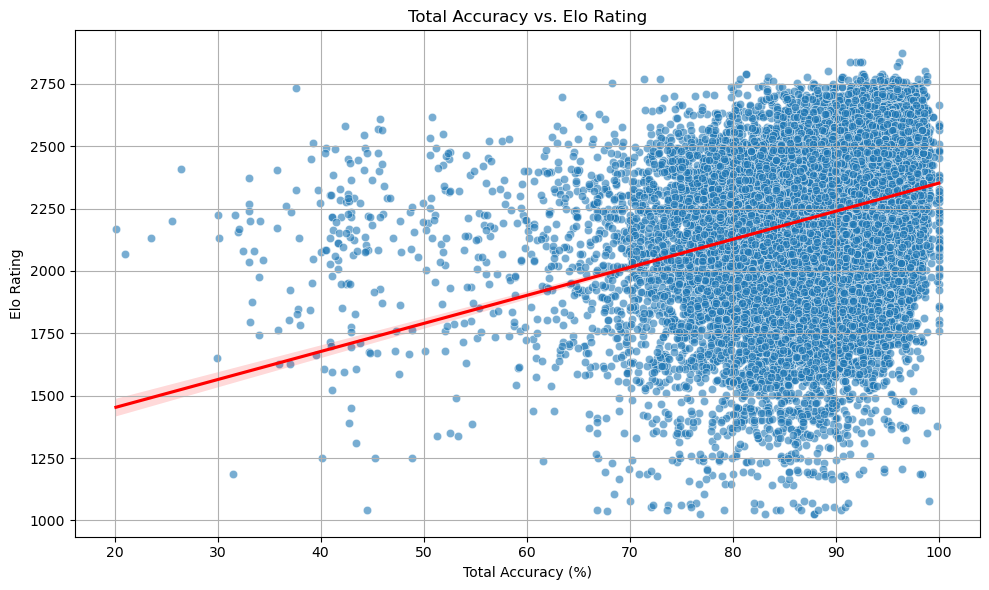

In [53]:
plot_data = new_summary_table.dropna(subset=['Total_Accuracy', 'Elo'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='Total_Accuracy', y='Elo', alpha=0.6)

# Add a regression line
sns.regplot(data=plot_data, x='Total_Accuracy', y='Elo', scatter=False, color='red')

# Customize the plot
plt.title('Total Accuracy vs. Elo Rating')
plt.xlabel('Total Accuracy (%)')
plt.ylabel('Elo Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1390918/171376250.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_accuracy_per_elo_bin = data.groupby('EloBin')['Total_Accuracy'].mean().reset_index()


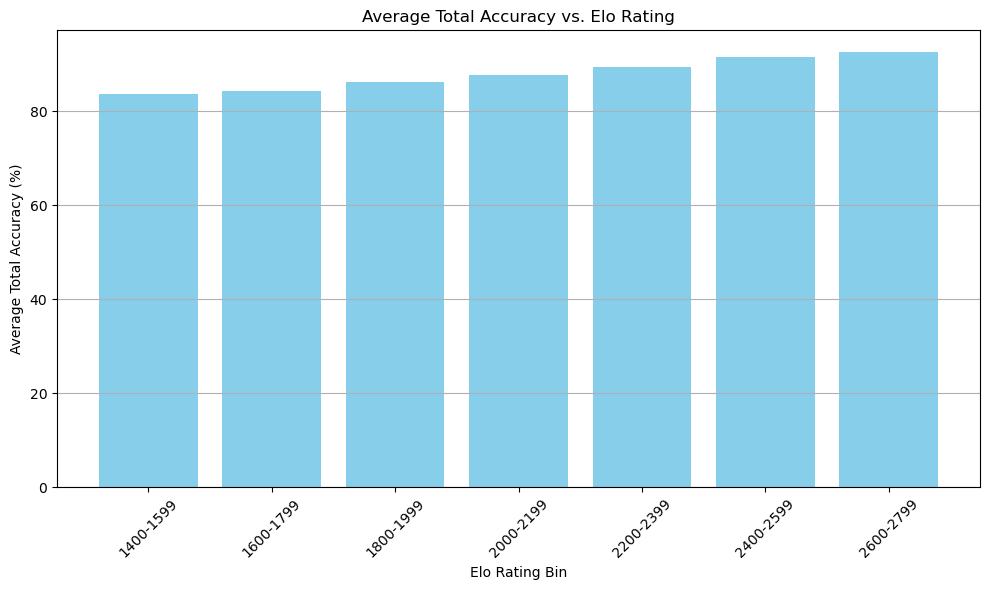

In [54]:

# Remove any rows with missing 'Elo' or 'Total_Accuracy'
data = new_summary_table.dropna(subset=['Elo', 'Total_Accuracy']).copy()

# Ensure 'Elo' is numeric
data['Elo'] = pd.to_numeric(data['Elo'], errors='coerce')

# Create Elo bins and labels
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]

elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1]
    upper = upper - 1  # Subtract 1 to make the upper limit inclusive
    label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)

# Assign Elo bins to the data
data['EloBin'] = pd.cut(
    data['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False  # Left-inclusive intervals
)

# Remove any rows where 'EloBin' is NaN (in case 'Elo' is outside the bins)
data = data.dropna(subset=['EloBin'])

# Compute average Total Accuracy per Elo bin
avg_accuracy_per_elo_bin = data.groupby('EloBin')['Total_Accuracy'].mean().reset_index()

# Sort the bins in order
avg_accuracy_per_elo_bin['EloBin'] = pd.Categorical(avg_accuracy_per_elo_bin['EloBin'], categories=elo_labels, ordered=True)
avg_accuracy_per_elo_bin = avg_accuracy_per_elo_bin.sort_values('EloBin')

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(avg_accuracy_per_elo_bin['EloBin'], avg_accuracy_per_elo_bin['Total_Accuracy'], color='skyblue')
plt.title('Average Total Accuracy vs. Elo Rating')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Total Accuracy (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()